## Goals and Privacy Requirements
- Task: create synthetic user locations that preserve aggregate patterns while ensuring differential privacy.
- Mechanism: Laplace noise on gridded counts; privacy budget split between counts and release.
- Risk controls: k-anonymity / l-diversity style checks on city buckets; t-closeness-inspired distance between raw and synthetic distributions.
- Utility checks: distribution similarity (Jensen-Shannon), spatial error summaries, visual overlays.
- Reproducible single-file pipeline: run top-to-bottom to produce data, metrics, and plots.

In [2]:
# Imports (top of notebook per README guidance)
import json
import math
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

In [3]:
# Configuration for reproducibility and privacy budgets
@dataclass
class DPConfig:
    seed: int = 7
    grid_size: int = 50              # square grid resolution over bounding box
    epsilon_counts: float = 1.0      # privacy budget for gridded counts
    epsilon_release: float = 0.5     # budget for releasing synthetic points per cell
    jitter_std_km: float = 1.0        # noise around cell centers when sampling synthetic points
    k_anonymity_k: int = 10
    l_diversity_l: int = 2
    t_closeness_thresh: float = 0.2  # max JS divergence between raw and synthetic per bucket

config = DPConfig()
rng = np.random.default_rng(config.seed)

## Step 1 — Build a realistic raw dataset (synthetic but non-private)
We emulate raw user check-ins across several metro areas (no real PII). Each user is assigned a home city center and jittered around it.

In [4]:
# Define metro centers (lat, lon) and relative popularity
metros = [
    {"city": "New York", "lat": 40.7128, "lon": -74.0060, "weight": 1.0},
    {"city": "Los Angeles", "lat": 34.0522, "lon": -118.2437, "weight": 0.75},
    {"city": "Chicago", "lat": 41.8781, "lon": -87.6298, "weight": 0.55},
    {"city": "Houston", "lat": 29.7604, "lon": -95.3698, "weight": 0.45},
    {"city": "Seattle", "lat": 47.6062, "lon": -122.3321, "weight": 0.35},
    {"city": "Miami", "lat": 25.7617, "lon": -80.1918, "weight": 0.30}
]

def km_to_deg(km: float) -> float:
    # Approx conversion at mid-latitudes (rough but fine for synthetic data)
    return km / 111.0

def generate_raw_locations(n_users: int = 5000) -> pd.DataFrame:
    weights = np.array([m["weight"] for m in metros], dtype=float)
    weights /= weights.sum()
    city_choices = rng.choice(len(metros), size=n_users, p=weights)
    records = []
    for idx in city_choices:
        m = metros[idx]
        # Local jitter: normal noise around city center (roughly ~3km std dev)
        lat = rng.normal(m["lat"], km_to_deg(3.0))
        lon = rng.normal(m["lon"], km_to_deg(3.0))
        records.append({"city": m["city"], "lat": lat, "lon": lon})
    return pd.DataFrame(records)

raw_df = generate_raw_locations()
raw_df.head()

,city,lat,lon
0,Chicago,41.889627,-87.607218
1,Seattle,47.626814,-122.340253
2,Houston,29.772073,-95.346990
3,New York,40.733475,-74.089414
4,Los Angeles,34.028139,-118.264669


## Step 2 — Differential privacy mechanisms on gridded counts
We grid the bounding box, add Laplace noise to each cell count (sensitivity=1), and synthesize new points from noisy counts.

In [5]:
# Bounding box around the metros for gridding
lat_min, lat_max = raw_df.lat.min() - km_to_deg(10), raw_df.lat.max() + km_to_deg(10)
lon_min, lon_max = raw_df.lon.min() - km_to_deg(10), raw_df.lon.max() + km_to_deg(10)

def laplace_noise(scale: float, size) -> np.ndarray:
    return rng.laplace(0.0, scale, size=size)

def to_grid_indices(lat, lon, grid_size):
    lat_idx = np.clip(((lat - lat_min) / (lat_max - lat_min) * grid_size).astype(int), 0, grid_size - 1)
    lon_idx = np.clip(((lon - lon_min) / (lon_max - lon_min) * grid_size).astype(int), 0, grid_size - 1)
    return lat_idx, lon_idx

def grid_counts(df: pd.DataFrame, grid_size: int) -> np.ndarray:
    counts = np.zeros((grid_size, grid_size), dtype=int)
    lat_idx, lon_idx = to_grid_indices(df.lat.values, df.lon.values, grid_size)
    for i, j in zip(lat_idx, lon_idx):
        counts[i, j] += 1
    return counts

def dp_grid_counts(df: pd.DataFrame, grid_size: int, epsilon: float) -> np.ndarray:
    counts = grid_counts(df, grid_size)
    scale = 1.0 / epsilon
    noisy = counts + laplace_noise(scale=scale, size=counts.shape)
    noisy = np.maximum(noisy, 0.0)
    return noisy

def sample_from_grid(noisy_counts: np.ndarray, n: int) -> tuple:
    flat = noisy_counts.flatten().astype(float)
    probs = flat / flat.sum()
    chosen = rng.choice(len(flat), size=n, p=probs)
    lat_idx = chosen // noisy_counts.shape[1]
    lon_idx = chosen % noisy_counts.shape[1]
    return lat_idx, lon_idx

def cell_center(lat_idx, lon_idx, grid_size):
    lat = lat_min + (lat_idx + 0.5) * (lat_max - lat_min) / grid_size
    lon = lon_min + (lon_idx + 0.5) * (lon_max - lon_min) / grid_size
    return lat, lon

def jitter_point(lat_center, lon_center, std_km):
    std_deg = km_to_deg(std_km)
    return rng.normal(lat_center, std_deg), rng.normal(lon_center, std_deg)

def generate_dp_synthetic(df: pd.DataFrame, cfg: DPConfig) -> pd.DataFrame:
    noisy_counts = dp_grid_counts(df, cfg.grid_size, cfg.epsilon_counts)
    lat_idx, lon_idx = sample_from_grid(noisy_counts, len(df))
    syn_records = []
    for i, j in zip(lat_idx, lon_idx):
        lat_c, lon_c = cell_center(i, j, cfg.grid_size)
        lat, lon = jitter_point(lat_c, lon_c, cfg.jitter_std_km)
        syn_records.append({"lat": lat, "lon": lon})
    return pd.DataFrame(syn_records)

dp_counts = dp_grid_counts(raw_df, config.grid_size, config.epsilon_counts)
syn_df = generate_dp_synthetic(raw_df, config)
syn_df.head()

,lat,lon
0,47.545633,-122.014535
1,25.800715,-80.152205
2,41.780740,-87.935060
3,41.777081,-75.285598
4,41.794485,-87.946436


## Step 3 — k-anonymity / l-diversity / t-closeness style checks
We coarse-grain locations to the nearest metro to assess group sizes and distribution similarity. These checks are informational safeguards on top of DP.

In [6]:
def nearest_city(lat, lon):
    dists = []
    for m in metros:
        d = (lat - m["lat"]) ** 2 + (lon - m["lon"]) ** 2
        dists.append(d)
    return metros[int(np.argmin(dists))]["city"]

raw_df["bucket"] = raw_df.apply(lambda r: nearest_city(r.lat, r.lon), axis=1)
syn_df["bucket"] = syn_df.apply(lambda r: nearest_city(r.lat, r.lon), axis=1)

def k_anonymity(df: pd.DataFrame, k: int) -> bool:
    sizes = df.groupby("bucket").size()
    return bool((sizes >= k).all())

def l_diversity(df: pd.DataFrame, l: int) -> bool:
    # City buckets are the quasi-identifier; diversity over grid-cell ids for illustration
    lat_idx, lon_idx = to_grid_indices(df.lat.values, df.lon.values, config.grid_size)
    df_tmp = df.copy()
    df_tmp["cell"] = list(zip(lat_idx, lon_idx))
    diverse = df_tmp.groupby("bucket")["cell"].nunique()
    return bool((diverse >= l).all())

def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
    p = p / p.sum()
    q = q / q.sum()
    m = 0.5 * (p + q)
    def kl(a, b):
        mask = (a > 0) & (b > 0)
        return np.sum(a[mask] * np.log(a[mask] / b[mask]))
    return 0.5 * kl(p, m) + 0.5 * kl(q, m)

def t_closeness(raw: pd.Series, syn: pd.Series, threshold: float) -> bool:
    common = sorted(set(raw.index).union(set(syn.index)))
    p = raw.reindex(common, fill_value=0).to_numpy(dtype=float)
    q = syn.reindex(common, fill_value=0).to_numpy(dtype=float)
    js = js_divergence(p, q)
    return bool(js <= threshold), js

raw_bucket_counts = raw_df.groupby("bucket").size()
syn_bucket_counts = syn_df.groupby("bucket").size()

k_ok = k_anonymity(syn_df, config.k_anonymity_k)
l_ok = l_diversity(syn_df, config.l_diversity_l)
t_ok, t_js = t_closeness(raw_bucket_counts, syn_bucket_counts, config.t_closeness_thresh)

privacy_checks = {"k_anonymity": k_ok, "l_diversity": l_ok, "t_closeness_ok": t_ok, "t_closeness_js": t_js}
privacy_checks

{'k_anonymity': True,
 'l_diversity': True,
 't_closeness_ok': True,
 't_closeness_js': np.float64(0.0015049895939289687)}

## Step 4 — Utility evaluation
We compare bucket distributions (JS divergence), spatial error (km), and show a small table.

In [7]:
from math import radians, sin, cos, asin, sqrt

def haversine_km(lat1, lon1, lat2, lon2):
    # Great-circle distance in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 6371.0 * 2 * asin(sqrt(a))

def spatial_error(raw: pd.DataFrame, syn: pd.DataFrame, sample: int = 2000) -> float:
    m = min(sample, len(raw), len(syn))
    raw_sample = raw.sample(m, random_state=config.seed)
    syn_sample = syn.sample(m, random_state=config.seed)
    errs = [haversine_km(r.lat, r.lon, s.lat, s.lon) for (_, r), (_, s) in zip(raw_sample.iterrows(), syn_sample.iterrows())]
    return float(np.mean(errs))

js_global = js_divergence(raw_bucket_counts.to_numpy(dtype=float), syn_bucket_counts.to_numpy(dtype=float))
avg_km_error = spatial_error(raw_df, syn_df)

utility_report = pd.DataFrame({
    "metric": ["JS divergence (buckets)", "Avg spatial error (km)"],
    "value": [js_global, avg_km_error]
})
utility_report

,metric,value
0,JS divergence (buckets),0.001505
1,Avg spatial error (km),2092.535462


## Step 5 — Visual comparisons (bottom cells per README)
Plots help eyeball that synthetic data follows high-level geography without revealing individuals.

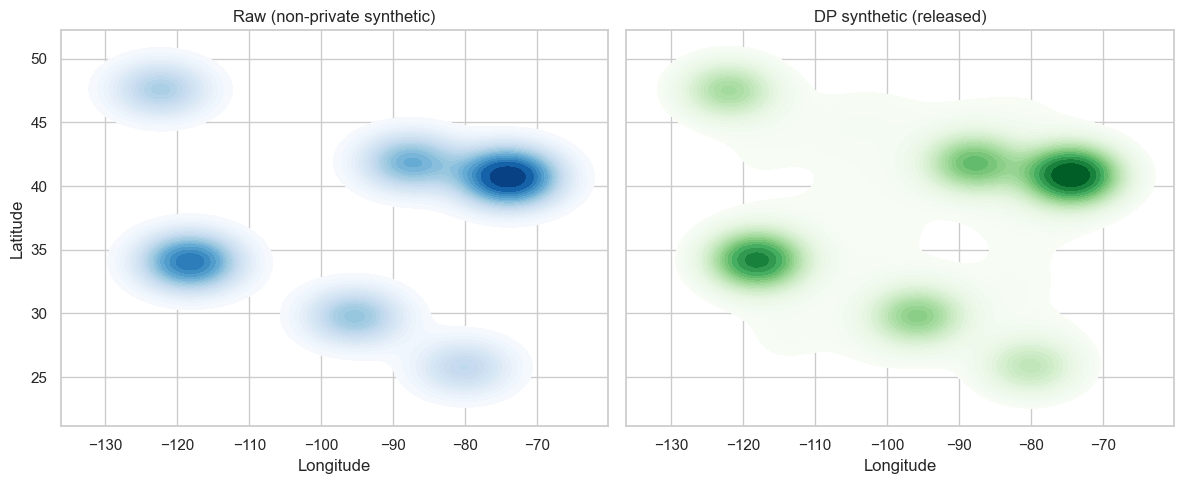

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
sns.kdeplot(data=raw_df, x="lon", y="lat", fill=True, cmap="Blues", levels=25, ax=axes[0])
axes[0].set_title("Raw (non-private synthetic)")
sns.kdeplot(data=syn_df, x="lon", y="lat", fill=True, cmap="Greens", levels=25, ax=axes[1])
axes[1].set_title("DP synthetic (released)")
for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

In [9]:
# Side-by-side bucket counts
bucket_compare = pd.DataFrame({
    "bucket": raw_bucket_counts.index,
    "raw_count": raw_bucket_counts.values,
    "dp_syn_count": syn_bucket_counts.reindex(raw_bucket_counts.index).values
}).set_index("bucket")
bucket_compare

,raw_count,dp_syn_count
bucket,,
Chicago,764,848
Houston,632,740
Los Angeles,1127,1153
Miami,438,440
New York,1503,1286
Seattle,536,533


## How to use / extend
- Adjust `epsilon_counts` and `epsilon_release` to trade privacy vs. fidelity (smaller epsilon = more noise).
- Change `grid_size` to tune spatial granularity; larger grids may need larger epsilon to stay useful.
- Swap the metro list for any bounding box you need; raw data generator stays synthetic.
- Add categorical attributes (e.g., venue type) and apply the same DP histogram + sampling pattern per attribute combination.
- Persist outputs: `syn_df.to_csv('dp_synthetic_locations.csv', index=False)` if you need a release artifact.